# Football Match Prediction Model v1

This notebook develops the first machine learning model for football match outcome prediction using the master dataset.

## Objectives:
- Load the master dataset with comprehensive match features
- Perform exploratory data analysis and feature engineering
- Build and evaluate prediction models
- Compare different algorithms and approaches
- Generate predictions and model insights

## Dataset Features:
- Match statistics (possession, shots, passes, etc.)
- Team wage information and squad details
- Historical form metrics (rolling 5-match averages)
- Rest days and contextual match information
- Both team and opponent perspectives

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import mutual_info_classif, f_classif
from scipy.stats import pearsonr,ranksums

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

c:\Users\50230\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


✓ Libraries imported successfully


In [2]:
# Set up paths
project_root = Path().resolve().parent.parent.parent
data_masters = project_root / 'data' / 'prod' / 'processed' / 'masters'
models_dir = project_root / 'models' / 'premier_league'

# Create models directory if it doesn't exist
models_dir.mkdir(parents=True, exist_ok=True)

print(f"Project root: {project_root}")
print(f"Masters data: {data_masters}")
print(f"Models directory: {models_dir}")

Project root: C:\Users\50230\OneDrive\Escritorio\Proyectos y trabajos\Personales\Pronósticos Football
Masters data: C:\Users\50230\OneDrive\Escritorio\Proyectos y trabajos\Personales\Pronósticos Football\data\prod\processed\masters
Models directory: C:\Users\50230\OneDrive\Escritorio\Proyectos y trabajos\Personales\Pronósticos Football\models\premier_league


## Data Loading

Load the master dataset created in the data engineering phase.

In [3]:
# Load master dataset (prefer parquet for efficiency)
dataset_file = data_masters / 'match_stats_master_complete_v1.parquet'

if dataset_file.exists():
    df = pd.read_parquet(dataset_file)
    print(f"✓ Dataset loaded successfully")
    print(f"  Shape: {df.shape}")
    print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
else:
    print("✗ Master dataset not found. Please run master_creation_v1.ipynb first.")
    df = None

✓ Dataset loaded successfully
  Shape: (5711, 236)
  Memory usage: 15.3 MB


## Feature Dropping

In [4]:
columnas_team_B_validacion = [
    'Aerials Won_favor_opponent',
    'Clearances_favor_opponent',
    'Corners_favor_opponent',
    'Crosses_favor_opponent',
    'Fouls_favor_opponent',
    'Goal Kicks_favor_opponent',
    'Interceptions_favor_opponent',
    'Long Balls_favor_opponent',
    'Offsides_favor_opponent',
    'Passing Accuracy_favor_opponent',
    'Possession_favor_opponent',
    'Saves_favor_opponent',
    'Shots on Target_favor_opponent',
    'Tackles_favor_opponent',
    'Throw Ins_favor_opponent',
    'Touches_favor_opponent',
    'Aerials Won_against_opponent',
    'Clearances_against_opponent',
    'Corners_against_opponent',
    'Crosses_against_opponent',
    'Fouls_against_opponent',
    'Goal Kicks_against_opponent',
    'Interceptions_against_opponent',
    'Long Balls_against_opponent',
    'Offsides_against_opponent',
    'Passing Accuracy_against_opponent',
    'Possession_against_opponent',
    'Saves_against_opponent',
    'Shots on Target_against_opponent',
    'Tackles_against_opponent',
    'Throw Ins_against_opponent',
    'Touches_against_opponent',
    'points_opponent',
    'goals_against'
]

columnas_team_A_validacion = [
    'Aerials Won_favor',
    'Clearances_favor',
    'Corners_favor',
    'Crosses_favor',
    'Fouls_favor',
    'Goal Kicks_favor',
    'Interceptions_favor',
    'Long Balls_favor',
    'Offsides_favor',
    'Passing Accuracy_favor',
    'Possession_favor',
    'Saves_favor',
    'Shots on Target_favor',
    'Tackles_favor',
    'Throw Ins_favor',
    'Touches_favor',
    'Aerials Won_against',
    'Clearances_against',
    'Corners_against',
    'Crosses_against',
    'Fouls_against',
    'Goal Kicks_against',
    'Interceptions_against',
    'Long Balls_against',
    'Offsides_against',
    'Passing Accuracy_against',
    'Possession_against',
    'Saves_against',
    'Shots on Target_against',
    'Tackles_against',
    'Throw Ins_against',
    'Touches_against',
    'points',
    'goals_for'
]


cols_drop = columnas_team_A_validacion + columnas_team_B_validacion

df.drop(cols_drop,axis=1,inplace=True)

## Feature Engineering & Data Preparation

Analyze the dataset structure and target variable distribution.

In [5]:
cols_add_A = [
 'age_mean',
 'squad_size',
 'age_max',
 'age_min',
 'avg_wage_dollars',
 'total_wage_bill_dollars',
 'max_wage_dollars',
 'min_wage_dollars'
]

cols_add_B = [
'opp_age_mean',
 'opp_squad_size',
 'opp_age_max',
 'opp_age_min',
 'opp_avg_wage_dollars',
 'opp_total_wage_bill_dollars',
 'opp_max_wage_dollars',
 'opp_min_wage_dollars' 
]

for columna in range(len(cols_add_A)):
    df[cols_add_A[columna] + '_diff'] = df[cols_add_A[columna]] - df[cols_add_B[columna]]

if df is not None:
    # Basic dataset info
    print("Dataset Overview:")
    print(f"  Rows: {len(df):,}")
    print(f"  Columns: {len(df.columns):,}")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"  Seasons: {sorted(df['season'].unique())}")
    print(f"  Teams: {len(df['team_id'].unique())} unique teams")
    
    # Target variable distribution
    print("\nTarget Variable (Result) Distribution:")
    result_counts = df['result'].value_counts()
    result_pct = df['result'].value_counts(normalize=True) * 100
    
    for result in ['W', 'D', 'L']:
        if result in result_counts:
            print(f"  {result}: {result_counts[result]:,} ({result_pct[result]:.1f}%)")
    
    # Missing values summary
    missing_summary = df.isnull().sum().sort_values(ascending=False)
    missing_pct = (missing_summary / len(df) * 100).round(1)
    
    print(f"\nColumns with missing values (top 10):")
    for col, missing in missing_summary.head(10).items():
        if missing > 0:
            print(f"  {col}: {missing:,} ({missing_pct[col]}%)")

Dataset Overview:
  Rows: 5,711
  Columns: 176
  Date range: 2019-08-04 00:00:00 to 2025-05-28 00:00:00
  Seasons: ['2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']
  Teams: 27 unique teams

Target Variable (Result) Distribution:
  W: 2,406 (42.1%)
  D: 1,257 (22.0%)
  L: 2,048 (35.9%)

Columns with missing values (top 10):
  rest_days_opponent_form_sum: 817 (14.3%)
  rest_days_opponent_form_avg: 817 (14.3%)
  points_opponent_form_avg: 794 (13.9%)
  Saves_favor_opponent_form_avg: 794 (13.9%)
  Offsides_favor_opponent_form_avg: 794 (13.9%)
  Offsides_favor_opponent_form_sum: 794 (13.9%)
  Passing Accuracy_favor_opponent_form_avg: 794 (13.9%)
  Passing Accuracy_favor_opponent_form_sum: 794 (13.9%)
  Possession_favor_opponent_form_avg: 794 (13.9%)
  Possession_favor_opponent_form_sum: 794 (13.9%)


In [6]:
df['dayofweek'] = df['dayofweek'].map({
      'Mon': 'midweek',    
      'Tue': 'midweek',    
      'Wed': 'midweek',    
      'Thu': 'midweek',    
      'Fri': 'Fri',    
      'Sat': 'Sat',    
      'Sun': 'Sun'
})

dummies = pd.get_dummies(
    df['dayofweek'],
    drop_first=False,
    dtype=int
)

df.drop('dayofweek', axis=1, inplace=True)

df = pd.concat([df, dummies], axis=1)

df['venue'] = df['venue'].map({
    'Away': 0,
    'Home': 1,
    'Neutral': 0
})

df['result'] = df['result'].astype('category')

## Feature Selection

### Features a evaluar

In [7]:
id_cols = [
    'date',
    'comp',
    'round',
    'season',
    'team_id',
    'full_match_report_url',
    'team_name',
    'opponent',
    'opponent_id',
    'referee',
    'start_time'
]


features = [
    'venue',
    'Aerials Won_favor_form_avg',
    'Aerials Won_favor_form_sum',
    'Clearances_favor_form_avg',
    'Clearances_favor_form_sum',
    'Corners_favor_form_avg',
    'Corners_favor_form_sum',
    'Crosses_favor_form_avg',
    'Crosses_favor_form_sum',
    'Fouls_favor_form_avg',
    'Fouls_favor_form_sum',
    'Goal Kicks_favor_form_avg',
    'Goal Kicks_favor_form_sum',
    'Interceptions_favor_form_avg',
    'Interceptions_favor_form_sum',
    'Long Balls_favor_form_avg',
    'Long Balls_favor_form_sum',
    'Offsides_favor_form_avg',
    'Offsides_favor_form_sum',
    'Passing Accuracy_favor_form_avg',
    'Passing Accuracy_favor_form_sum',
    'Possession_favor_form_avg',
    'Possession_favor_form_sum',
    'Saves_favor_form_avg',
    'Saves_favor_form_sum',
    'Shots on Target_favor_form_avg',
    'Shots on Target_favor_form_sum',
    'Tackles_favor_form_avg',
    'Tackles_favor_form_sum',
    'Throw Ins_favor_form_avg',
    'Throw Ins_favor_form_sum',
    'Touches_favor_form_avg',
    'Touches_favor_form_sum',
    'Aerials Won_against_form_avg',
    'Aerials Won_against_form_sum',
    'Clearances_against_form_avg',
    'Clearances_against_form_sum',
    'Corners_against_form_avg',
    'Corners_against_form_sum',
    'Crosses_against_form_avg',
    'Crosses_against_form_sum',
    'Fouls_against_form_avg',
    'Fouls_against_form_sum',
    'Goal Kicks_against_form_avg',
    'Goal Kicks_against_form_sum',
    'Interceptions_against_form_avg',
    'Interceptions_against_form_sum',
    'Long Balls_against_form_avg',
    'Long Balls_against_form_sum',
    'Offsides_against_form_avg',
    'Offsides_against_form_sum',
    'Passing Accuracy_against_form_avg',
    'Passing Accuracy_against_form_sum',
    'Possession_against_form_avg',
    'Possession_against_form_sum',
    'Saves_against_form_avg',
    'Saves_against_form_sum',
    'Shots on Target_against_form_avg',
    'Shots on Target_against_form_sum',
    'Tackles_against_form_avg',
    'Tackles_against_form_sum',
    'Throw Ins_against_form_avg',
    'Throw Ins_against_form_sum',
    'Touches_against_form_avg',
    'Touches_against_form_sum',
    'points_form_avg',
    'points_form_sum',
    'rest_days',
    'rest_days_form_avg',
    'rest_days_form_sum',
    'age_mean',
    'squad_size',
    'age_max',
    'age_min',
    'avg_wage_dollars',
    'total_wage_bill_dollars',
    'max_wage_dollars',
    'min_wage_dollars',
    'Aerials Won_favor_opponent_form_avg',
    'Aerials Won_favor_opponent_form_sum',
    'Clearances_favor_opponent_form_avg',
    'Clearances_favor_opponent_form_sum',
    'Corners_favor_opponent_form_avg',
    'Corners_favor_opponent_form_sum',
    'Crosses_favor_opponent_form_avg',
    'Crosses_favor_opponent_form_sum',
    'Fouls_favor_opponent_form_avg',
    'Fouls_favor_opponent_form_sum',
    'Goal Kicks_favor_opponent_form_avg',
    'Goal Kicks_favor_opponent_form_sum',
    'Interceptions_favor_opponent_form_avg',
    'Interceptions_favor_opponent_form_sum',
    'Long Balls_favor_opponent_form_avg',
    'Long Balls_favor_opponent_form_sum',
    'Offsides_favor_opponent_form_avg',
    'Offsides_favor_opponent_form_sum',
    'Passing Accuracy_favor_opponent_form_avg',
    'Passing Accuracy_favor_opponent_form_sum',
    'Possession_favor_opponent_form_avg',
    'Possession_favor_opponent_form_sum',
    'Saves_favor_opponent_form_avg',
    'Saves_favor_opponent_form_sum',
    'Shots on Target_favor_opponent_form_avg',
    'Shots on Target_favor_opponent_form_sum',
    'Tackles_favor_opponent_form_avg',
    'Tackles_favor_opponent_form_sum',
    'Throw Ins_favor_opponent_form_avg',
    'Throw Ins_favor_opponent_form_sum',
    'Touches_favor_opponent_form_avg',
    'Touches_favor_opponent_form_sum',
    'Aerials Won_against_opponent_form_avg',
    'Aerials Won_against_opponent_form_sum',
    'Clearances_against_opponent_form_avg',
    'Clearances_against_opponent_form_sum',
    'Corners_against_opponent_form_avg',
    'Corners_against_opponent_form_sum',
    'Crosses_against_opponent_form_avg',
    'Crosses_against_opponent_form_sum',
    'Fouls_against_opponent_form_avg',
    'Fouls_against_opponent_form_sum',
    'Goal Kicks_against_opponent_form_avg',
    'Goal Kicks_against_opponent_form_sum',
    'Interceptions_against_opponent_form_avg',
    'Interceptions_against_opponent_form_sum',
    'Long Balls_against_opponent_form_avg',
    'Long Balls_against_opponent_form_sum',
    'Offsides_against_opponent_form_avg',
    'Offsides_against_opponent_form_sum',
    'Passing Accuracy_against_opponent_form_avg',
    'Passing Accuracy_against_opponent_form_sum',
    'Possession_against_opponent_form_avg',
    'Possession_against_opponent_form_sum',
    'Saves_against_opponent_form_avg',
    'Saves_against_opponent_form_sum',
    'Shots on Target_against_opponent_form_avg',
    'Shots on Target_against_opponent_form_sum',
    'Tackles_against_opponent_form_avg',
    'Tackles_against_opponent_form_sum',
    'Throw Ins_against_opponent_form_avg',
    'Throw Ins_against_opponent_form_sum',
    'Touches_against_opponent_form_avg',
    'Touches_against_opponent_form_sum',
    'points_opponent_form_avg',
    'points_opponent_form_sum',
    'rest_days_opponent',
    'rest_days_opponent_form_avg',
    'rest_days_opponent_form_sum',
    'opp_age_mean',
    'opp_squad_size',
    'opp_age_max',
    'opp_age_min',
    'opp_avg_wage_dollars',
    'opp_total_wage_bill_dollars',
    'opp_max_wage_dollars',
    'opp_min_wage_dollars',
    'age_mean_diff',
    'squad_size_diff',
    'age_max_diff',
    'age_min_diff',
    'avg_wage_dollars_diff',
    'total_wage_bill_dollars_diff',
    'max_wage_dollars_diff',
    'min_wage_dollars_diff',
    'Fri',
    'Sat',
    'Sun',
    'midweek' 
]   

target = [
    'result'
    ]

### Functions definitions

In [8]:
def mrmr_feature_selection(X, y, n_features=20, relevance_method='mutual_info', verbose=True):
      """
      Maximum Relevance Minimum Redundancy featureselection

      Parameters:
      -----------
      X : array-like, shape (n_samples, n_features)
          Feature matrix
      y : array-like, shape (n_samples,)
          Binary target variable (0/1)
      n_features : int
          Number of features to select
      relevance_method : str, 'mutual_info' or 'anova'
          Method to calculate relevance
      verbose : bool
          Print progress

      Returns:
      --------
      selected_features : list
          Indices of selected features
      scores : dict
          Dictionary with relevance and redundancy scores      
      """

      if not isinstance(X, np.ndarray):
          X = np.array(X)
      if not isinstance(y, np.ndarray):
          y = np.array(y)

      n_samples, n_total_features = X.shape
      selected_features = []
      remaining_features = list(range(n_total_features))       

      # Calculate relevance scores for all features
      if relevance_method == 'mutual_info':
          relevance_scores = mutual_info_classif(X, y, random_state=42)
      elif relevance_method == 'anova':
          f_scores, _ = f_classif(X, y)
          relevance_scores = f_scores
      else:
          raise ValueError("relevance_method must be'mutual_info' or 'anova'")

      # Select first feature with highest relevance
      first_feature = np.argmax(relevance_scores)
      selected_features.append(first_feature)
      remaining_features.remove(first_feature)

      if verbose:
          print(f"Selected feature 1: {first_feature}(relevance: {relevance_scores[first_feature]:.4f})")

      # Iteratively select remaining features
      for i in range(1, min(n_features, n_total_features)):
          mrmr_scores = []

          for candidate in remaining_features:
              # Relevance score
              relevance = relevance_scores[candidate]

              # Calculate redundancy with already selected features
              redundancy_scores = []
              for selected_feat in selected_features:
                  # Use absolute correlation as redundancy measure
                  corr_coef, _ = pearsonr(X[:, candidate], X[:, selected_feat])
                  redundancy_scores.append(abs(corr_coef))     

              # Average redundancy
              avg_redundancy = np.mean(redundancy_scores) if redundancy_scores else 0

              # MrMr score: maximize relevance, minimize redundancy
              mrmr_score = relevance - avg_redundancy
              mrmr_scores.append(mrmr_score)

          # Select feature with highest MrMr score
          best_idx = np.argmax(mrmr_scores)
          best_feature = remaining_features[best_idx]

          selected_features.append(best_feature)
          remaining_features.remove(best_feature)

          if verbose:
              print(f"Selected feature {i+1}:{best_feature} "f"(relevance:{relevance_scores[best_feature]:.4f}, "
                    f"mrmr_score:{mrmr_scores[best_idx]:.4f})")

      scores = {
          'relevance_scores': relevance_scores,
          'selected_features': selected_features,
          'method': relevance_method
      }

      return selected_features, scores

In [9]:
def calculate_iv_woe(X, y, n_bins=10, min_bin_size=0.05):
      """
      Calculate Information Value and Weight of Evidence for features

      Parameters:
      -----------
      X : array-like, shape (n_samples, n_features)
          Feature matrix
      y : array-like, shape (n_samples,)
          Binary target variable (0/1)
      n_bins : int
          Number of bins for continuous variables
      min_bin_size : float
          Minimum proportion of samples per bin

      Returns:
      --------
      results : dict
          Dictionary with IV, WoE, and binning information
   for each feature
      """

      if not isinstance(X, pd.DataFrame):
          X = pd.DataFrame(X)
      if not isinstance(y, pd.Series):
          y = pd.Series(y)

      results = {}

      for col_idx, column in enumerate(X.columns):
          feature_data = X[column].copy()

          # Handle missing values
          non_missing_mask = ~feature_data.isna()
          if non_missing_mask.sum() == 0:
              continue

          feature_clean = feature_data[non_missing_mask]
          y_clean = y[non_missing_mask]

          # Determine if feature is continuous or categorical
          unique_values = len(feature_clean.unique())

          if unique_values > n_bins:  # Continuous variable
              # Create bins using quantiles
              try:
                  feature_binned, bin_edges = pd.qcut(
                      feature_clean,
                      q=n_bins,
                      duplicates='drop',
                      retbins=True
                  )
                  bin_labels = [f"Bin_{i+1}" for i in range(len(bin_edges)-1)]
                  feature_binned = pd.qcut(
                      feature_clean,
                      q=n_bins,
                      labels=bin_labels,
                      duplicates='drop'
                  )
              except Exception:
                  # Fallback to equal-width binning
                  feature_binned = pd.cut(feature_clean, bins=n_bins)
          else:  # Categorical variable
              feature_binned = feature_clean.astype(str)

          # Create crosstab
          crosstab = pd.crosstab(feature_binned, y_clean)

          # Ensure we have both classes
          if 0 not in crosstab.columns:
              crosstab[0] = 0
          if 1 not in crosstab.columns:
              crosstab[1] = 0

          # Calculate totals
          total_good = crosstab[0].sum()  # Class 0 (non-events)
          total_bad = crosstab[1].sum()   # Class 1 (events)

          if total_good == 0 or total_bad == 0:
              continue

          # Calculate WoE and IV for each bin
          woe_values = []
          iv_components = []
          bin_info = []

          for bin_name in crosstab.index:
              good_count = crosstab.loc[bin_name, 0]
              bad_count = crosstab.loc[bin_name, 1]
              total_count = good_count + bad_count

              # Skip bins that are too small
              if total_count / len(y_clean) < min_bin_size:
                  continue

              # Calculate proportions (add small constant to avoid division by zero)
              good_rate = (good_count + 0.001) / (total_good + 0.001)
              bad_rate = (bad_count + 0.001) / (total_bad + 0.001)

              # Weight of Evidence
              woe = np.log(good_rate / bad_rate)

              # Information Value component
              iv_component = (good_rate - bad_rate) * woe

              woe_values.append(woe)
              iv_components.append(iv_component)

              bin_info.append({
                  'bin': bin_name,
                  'good_count': good_count,
                  'bad_count': bad_count,
                  'good_rate': good_rate,
                  'bad_rate': bad_rate,
                  'woe': woe,
                  'iv_component': iv_component
              })

          # Total Information Value
          total_iv = sum(iv_components)

          # IV Interpretation
          if total_iv < 0.02:
              iv_strength = "Not useful"
          elif total_iv < 0.1:
              iv_strength = "Weak"
          elif total_iv < 0.3:
              iv_strength = "Medium"
          elif total_iv < 0.5:
              iv_strength = "Strong"
          else:
              iv_strength = "Suspicious"

          results[f'feature_{col_idx}'] = {
              'information_value': total_iv,
              'iv_strength': iv_strength,
              'woe_values': woe_values,
              'bin_details': bin_info,
              'feature_name': column if hasattr(X, 'columns') else f'feature_{col_idx}'}

      return results

def rank_features_by_iv(iv_results, top_k=None):
    """
    Rank features by Information Value

    Parameters:
    -----------
    iv_results : dict Results from calculate_iv_woe function
    top_k : int, optional Number of top features to return

    Returns:
    --------
    ranked_features : pd.DataFrame Features ranked by IV with strength interpretation
    """

    ranking_data = []
    for feature_key, results in iv_results.items():
        ranking_data.append({
            'feature': results['feature_name'],
            'information_value':
results['information_value'],
            'iv_strength': results['iv_strength']
        })

    ranking_df = pd.DataFrame(ranking_data)
    ranking_df = ranking_df.sort_values('information_value', ascending=False)

    if top_k:
        ranking_df = ranking_df.head(top_k)

    return ranking_df

In [10]:
def wilcoxon_feature_selection(X, y, alpha=0.05, alternative='two-sided'):
    """
    Perform Wilcoxon rank-sum test for feature selection in binary classification

    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features) Feature matrix
    y : array-like, shape (n_samples,) Binary target variable (0/1)
    alpha : float Significance level for hypothesis testing
    alternative : str 'two-sided', 'less', or 'greater'

    Returns:
    --------
    results : dict Dictionary with test statistics, p-values, and significance for each feature
    """

    if not isinstance(X, np.ndarray):
        X = np.array(X)
    if not isinstance(y, np.ndarray):
        y = np.array(y)

    n_features = X.shape[1]
    results = {
        'feature_indices': [],
        'test_statistics': [],
        'p_values': [],
        'is_significant': [],
        'effect_sizes': [],
        'class_medians': []
    }

    # Get indices for each class
    class_0_idx = (y == 0)
    class_1_idx = (y == 1)

    for feature_idx in range(n_features):
        feature_values = X[:, feature_idx]

        # Remove missing values
        valid_mask = ~np.isnan(feature_values)
        feature_clean = feature_values[valid_mask]
        y_clean = y[valid_mask]

        if len(feature_clean) == 0:
            continue

        # Split feature values by class
        class_0_values = feature_clean[y_clean == 0]
        class_1_values = feature_clean[y_clean == 1]

        if len(class_0_values) == 0 or len(class_1_values) == 0:
            continue

        # Perform Wilcoxon rank-sum test (Mann-Whitney U test)
        try:
            statistic, p_value = ranksums(class_0_values, class_1_values, alternative=alternative)

            # Calculate effect size (rank-biserial correlation)
            n1, n2 = len(class_0_values), len(class_1_values)
            U1 = n1 * n2 + n1 * (n1 + 1) / 2 - statistic
            effect_size = 1 - (2 * U1) / (n1 * n2)  # rank-biserial correlation

            # Calculate medians for interpretation
            median_0 = np.median(class_0_values)
            median_1 = np.median(class_1_values)

            # Determine significance
            is_significant = p_value < alpha
            results['feature_indices'].append(feature_idx)
            results['test_statistics'].append(statistic)
            results['p_values'].append(p_value)
            results['is_significant'].append(is_significant)
            results['effect_sizes'].append(abs(effect_size))  # Use absolute value
            results['class_medians'].append((median_0,median_1))

        except Exception as e:
            # Handle cases where test cannot be performed
            print(f"Warning: Could not perform test for feature {feature_idx}: {e}")
        continue

    return results

def rank_features_by_wilcoxon(wilcoxon_results,sort_by='p_value', top_k=None):
    """
    Rank features based on Wilcoxon test results

    Parameters:
    -----------
    wilcoxon_results : dict
        Results from wilcoxon_feature_selection function
    sort_by : str
        'p_value' (ascending) or 'effect_size' (descending)
    top_k : int, optional
        Number of top features to return

    Returns:
    --------
    ranked_features : pd.DataFrame
        Features ranked by specified criteria
    """

    ranking_data = {
        'feature_index': wilcoxon_results['feature_indices'],
        'p_value': wilcoxon_results['p_values'],
        'effect_size': wilcoxon_results['effect_sizes'],
        'is_significant': wilcoxon_results['is_significant'],
        'test_statistic': wilcoxon_results['test_statistics']
    }

    # Add median differences for interpretation
    median_diffs = []
    for medians in wilcoxon_results['class_medians']:
        median_diffs.append(abs(medians[1] - medians[0]))
    ranking_data['median_difference'] = median_diffs

    ranking_df = pd.DataFrame(ranking_data)

    # Sort by specified criteria
    if sort_by == 'p_value':
        ranking_df = ranking_df.sort_values('p_value', ascending=True)
    elif sort_by == 'effect_size':
        ranking_df = ranking_df.sort_values('effect_size', ascending=False)
    else:
        raise ValueError("sort_by must be 'p_value' or 'effect_size'")

    if top_k:
        ranking_df = ranking_df.head(top_k)

    return ranking_df

In [11]:
df['binary_w'] = df['result'].map(
    {
        'W':1,
        'L':0,
        'D':0
    }
)

df['binary_d'] = df['result'].map(
    {
        'W':0,
        'L':0,
        'D':1
    }
)

df['binary_l'] = df['result'].map(
    {
        'W':0,
        'L':1,
        'D':0
    }
)

df_no_nulls = df.dropna()

## Feature Selection Winning

In [12]:
# # #INFORMACION MRMR
# indexes_w = mrmr_feature_selection(df_no_nulls[features], df_no_nulls['binary_w'], n_features=70, relevance_method='mutual_info', verbose=False)
# features_mutual_w = [features[i] for i in indexes_w[0]]

# indexes_w = mrmr_feature_selection(df_no_nulls[features], df_no_nulls['binary_w'], n_features=70, relevance_method='anova', verbose=False)
# features_anova_w = [features[i] for i in indexes_w[0]]

# woes_ivs_w = calculate_iv_woe(df_no_nulls[features], df_no_nulls['binary_w'])
# ivs_w = list(rank_features_by_iv(woes_ivs_w)['feature'].iloc[:70])

# indices = list(rank_features_by_wilcoxon(
#     wilcoxon_feature_selection(df_no_nulls[features], df_no_nulls['binary_w'], alpha=0.05, alternative='two-sided')
# )['feature_index'])


# wilcoxon_w = [features[i] for i in indices][:70]


## Feature Selection for Drawing

In [13]:
# # #INFORMACION MRMR
# indexes_d = mrmr_feature_selection(df_no_nulls[features], df_no_nulls['binary_d'], n_features=70, relevance_method='mutual_info', verbose=False)
# features_mutual_d = [features[i] for i in indexes_d[0]]

# indexes_d = mrmr_feature_selection(df_no_nulls[features], df_no_nulls['binary_d'], n_features=70, relevance_method='anova', verbose=False)
# features_anova_d = [features[i] for i in indexes_d[0]]

# woes_ivs_d = calculate_iv_woe(df_no_nulls[features], df_no_nulls['binary_d'])
# ivs_d = list(rank_features_by_iv(woes_ivs_d)['feature'].iloc[:70])

# indices = list(rank_features_by_wilcoxon(
#     wilcoxon_feature_selection(df_no_nulls[features], df_no_nulls['binary_d'], alpha=0.05, alternative='two-sided')
# )['feature_index'])

# wilcoxon_d = [features[i] for i in indices][:70]

## Feature Selection for Loosing

In [14]:
# # #INFORMACION MRMR
# indexes_l = mrmr_feature_selection(df_no_nulls[features], df_no_nulls['binary_l'], n_features=70, relevance_method='mutual_info', verbose=False)
# features_mutual_l = [features[i] for i in indexes_l[0]]

# indexes_l = mrmr_feature_selection(df_no_nulls[features], df_no_nulls['binary_l'], n_features=70, relevance_method='anova', verbose=False)
# features_anova_l = [features[i] for i in indexes_l[0]]

# woes_ivs_l = calculate_iv_woe(df_no_nulls[features], df_no_nulls['binary_l'])
# ivs_l = list(rank_features_by_iv(woes_ivs_l)['feature'].iloc[:70])

# indices = list(rank_features_by_wilcoxon(
#     wilcoxon_feature_selection(df_no_nulls[features], df_no_nulls['binary_l'], alpha=0.05, alternative='two-sided')
# )['feature_index'])

# wilcoxon_l = [features[i] for i in indices][:70]

## Feature Selection total

In [15]:
# features_w = list(
#     set(
#     features_mutual_w + features_anova_w + ivs_w + wilcoxon_w
# )
# )

# features_d = list(
#     set(
#     features_mutual_d + features_anova_d + ivs_d + wilcoxon_d
# )
# )

# features_l = list(
#     set(
#     features_mutual_l + features_anova_l + ivs_l + wilcoxon_l
# )
# )

# list(set(features_w + features_d + features_l))

## Data Preparation for ML

In [48]:
df_train = df[df['season']!='2024-2025']
df_test = df[df['season']=='2024-2025']


X_train = df_train[id_cols + features]
y_train = df_train['result']

X_test = df_test[id_cols + features]
y_test = df_test['result']

## Model Training & Evaluation

Train multiple machine learning models and compare their performance.

## Step 1: Win vs No-Win Binary Classification

In [71]:
# Step 1: Win vs No-Win Binary Classification
print("="*80)
print("STEP 1: WIN vs NO-WIN BINARY CLASSIFICATION")
print("="*80)

# Import XGBoost
import xgboost as xgb
from sklearn.metrics import log_loss, roc_auc_score

# Prepare Win vs No-Win data
print("Preparing Win vs No-Win data...")

# Features (using your full features list)
X_train_win = df_train[features].copy()
X_test_win = df_test[features].copy()

# Target: Win=1, Draw/Loss=0
y_train_win = df_train['binary_w'].values
y_test_win = df_test['binary_w'].values

print("Data overview:")
print(f"  Training features: {X_train_win.shape}")
print(f"  Test features: {X_test_win.shape}")
print(f"  Training wins: {y_train_win.sum():,} ({y_train_win.mean():.1%})")
print(f"  Test wins: {y_test_win.sum():,} ({y_test_win.mean():.1%})")
print(f"  Missing values - Train: {X_train_win.isnull().sum().sum()}, Test: {X_test_win.isnull().sum().sum()}")

STEP 1: WIN vs NO-WIN BINARY CLASSIFICATION
Preparing Win vs No-Win data...
Data overview:
  Training features: (4758, 167)
  Test features: (953, 167)
  Training wins: 2,004 (42.1%)
  Test wins: 402 (42.2%)
  Missing values - Train: 58254, Test: 10767


## Step 2: Hyperparameter Optimization to Maximize KS

In [72]:
# Step 1: Win vs No-Win Binary Classification
print("="*80)
print("STEP 1: WIN vs NO-WIN BINARY CLASSIFICATION")
print("="*80)

# Import XGBoost and additional metrics
import xgboost as xgb
from sklearn.metrics import log_loss, roc_auc_score, classification_report, confusion_matrix
from scipy import stats

# Prepare Win vs No-Win data
print("Preparing Win vs No-Win data...")

# Features (using your full features list)
X_train_win = df_train[features].copy()
X_test_win = df_test[features].copy()

# Target: Win=1, Draw/Loss=0
y_train_win = df_train['binary_w'].values
y_test_win = df_test['binary_w'].values

print("Data overview:")
print(f"  Training features: {X_train_win.shape}")
print(f"  Test features: {X_test_win.shape}")
print(f"  Training wins: {y_train_win.sum():,} ({y_train_win.mean():.1%})")
print(f"  Test wins: {y_test_win.sum():,} ({y_test_win.mean():.1%})")
print(f"  Missing values - Train: {X_train_win.isnull().sum().sum()}, Test: {X_test_win.isnull().sum().sum()}")

# Create baseline Win vs No-Win model
print(f"\nCreating baseline XGBoost model...")
win_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Train baseline model
win_model.fit(X_train_win, y_train_win)

# Get baseline predictions
train_pred_proba_win = win_model.predict_proba(X_train_win)[:, 1]
test_pred_proba_win = win_model.predict_proba(X_test_win)[:, 1]

print("✅ Baseline model trained successfully!")

STEP 1: WIN vs NO-WIN BINARY CLASSIFICATION
Preparing Win vs No-Win data...
Data overview:
  Training features: (4758, 167)
  Test features: (953, 167)
  Training wins: 2,004 (42.1%)
  Test wins: 402 (42.2%)
  Missing values - Train: 58254, Test: 10767

Creating baseline XGBoost model...
✅ Baseline model trained successfully!


In [73]:
# Step 2: Hyperparameter Optimization to Maximize KS
print("\n" + "="*80)
print("STEP 2: HYPERPARAMETER OPTIMIZATION TO MAXIMIZE KS")
print("="*80)

from sklearn.model_selection import ParameterGrid

def calculate_ks_statistic(y_true, y_pred_proba):
    """Calculate KS statistic for binary classification"""
    # Separate probabilities by class
    prob_class_0 = y_pred_proba[y_true == 0]  # No-Win
    prob_class_1 = y_pred_proba[y_true == 1]  # Win
    
    # Perform KS test
    ks_stat, ks_pvalue = stats.ks_2samp(prob_class_0, prob_class_1)
    return ks_stat, ks_pvalue

# Get baseline KS
baseline_ks, baseline_p = calculate_ks_statistic(y_test_win, test_pred_proba_win)
baseline_auc = roc_auc_score(y_test_win, test_pred_proba_win)

print(f"Baseline performance:")
print(f"  KS Statistic: {baseline_ks:.4f}")
print(f"  AUC: {baseline_auc:.4f}")

# Define hyperparameter grid for KS optimization
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 0.5, 1.0]
}

print(f"\nHyperparameter optimization:")
total_combinations = 1
for param, values in param_grid.items():
    total_combinations *= len(values)
print(f"  Total combinations: {total_combinations:,}")
print(f"  This is too many - using random search...")

# Random search approach (sample subset of combinations)
from sklearn.model_selection import ParameterSampler
import itertools

# Sample 50 random combinations
param_sampler = ParameterSampler(param_grid, n_iter=50, random_state=42)

best_ks = 0
best_params = None
best_model = None
results = []

print(f"\nTesting 50 random parameter combinations...")

for i, params in enumerate(param_sampler):
    # Create model with current parameters
    current_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        verbosity=0,
        **params
    )
    
    # Train model
    current_model.fit(X_train_win, y_train_win)
    
    # Get test predictions
    test_proba = current_model.predict_proba(X_test_win)[:, 1]
    
    # Calculate KS
    ks_stat, ks_p = calculate_ks_statistic(y_test_win, test_proba)
    auc_score = roc_auc_score(y_test_win, test_proba)
    
    # Store results
    results.append({
        'params': params,
        'ks_stat': ks_stat,
        'auc': auc_score,
        'ks_pvalue': ks_p
    })
    
    # Track best KS
    if ks_stat > best_ks:
        best_ks = ks_stat
        best_params = params
        best_model = current_model
    
    if (i + 1) % 10 == 0:
        print(f"  Completed {i + 1}/50 combinations... Best KS so far: {best_ks:.4f}")

print(f"\n🎉 Optimization completed!")
print(f"Best KS Statistic: {best_ks:.4f} (vs baseline: {baseline_ks:.4f})")
print(f"Improvement: {best_ks - baseline_ks:+.4f}")

print(f"\nBest parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Store optimized model
win_model_optimized = best_model
train_pred_proba_opt = win_model_optimized.predict_proba(X_train_win)[:, 1]
test_pred_proba_opt = win_model_optimized.predict_proba(X_test_win)[:, 1]


STEP 2: HYPERPARAMETER OPTIMIZATION TO MAXIMIZE KS
Baseline performance:
  KS Statistic: 0.2208
  AUC: 0.6353

Hyperparameter optimization:
  Total combinations: 3,888
  This is too many - using random search...

Testing 50 random parameter combinations...
  Completed 10/50 combinations... Best KS so far: 0.2991
  Completed 20/50 combinations... Best KS so far: 0.2991
  Completed 30/50 combinations... Best KS so far: 0.2993
  Completed 40/50 combinations... Best KS so far: 0.2993
  Completed 50/50 combinations... Best KS so far: 0.2993

🎉 Optimization completed!
Best KS Statistic: 0.2993 (vs baseline: 0.2208)
Improvement: +0.0785

Best parameters:
  subsample: 0.7
  reg_lambda: 1.0
  reg_alpha: 0.5
  n_estimators: 300
  min_child_weight: 3
  max_depth: 4
  learning_rate: 0.01


In [80]:
# Simple KS Visualization Function
def plot_ks_simple(y_true, y_prob, title="KS Analysis"):
    """
    Simple function to plot CDFs and highlight KS statistic
    
    Parameters:
    y_true: actual labels (0,1)
    y_prob: predicted probabilities 
    title: plot title
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    
    # Separate probabilities by class
    prob_0 = y_prob[y_true == 0]  # Class 0 probabilities
    prob_1 = y_prob[y_true == 1]  # Class 1 probabilities
    
    # Calculate KS statistic
    ks_stat, ks_pvalue = stats.ks_2samp(prob_0, prob_1)
    
    # Create probability range
    x = np.linspace(0, 1, 100)
    
    # Calculate CDFs
    cdf_0 = [np.mean(prob_0 <= threshold) for threshold in x]
    cdf_1 = [np.mean(prob_1 <= threshold) for threshold in x]
    
    # Find KS point (maximum difference)
    differences = [abs(c1 - c0) for c0, c1 in zip(cdf_0, cdf_1)]
    ks_idx = np.argmax(differences)
    ks_x = x[ks_idx]
    ks_y0 = cdf_0[ks_idx]
    ks_y1 = cdf_1[ks_idx]
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Plot CDFs
    ax.plot(x, cdf_0, 'r-', linewidth=2, label='Class 0 (No-Win) CDF')
    ax.plot(x, cdf_1, 'b-', linewidth=2, label='Class 1 (Win) CDF')
    
    # Highlight KS point
    ax.plot([ks_x, ks_x], [ks_y0, ks_y1], 'k-', linewidth=4, 
            label=f'KS = {ks_stat:.3f}')
    ax.plot(ks_x, ks_y0, 'ro', markersize=8)
    ax.plot(ks_x, ks_y1, 'bo', markersize=8)
    
    # Labels and formatting
    ax.set_xlabel('Predicted Probability', fontsize=12)
    ax.set_ylabel('Cumulative Probability', fontsize=12)
    ax.set_title(f'{title}\nKS = {ks_stat:.3f}, p-value = {ks_pvalue:.3e}', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Add KS interpretation text
    if ks_stat > 0.3:
        interpretation = "Excellent separation"
    elif ks_stat > 0.2:
        interpretation = "Good separation"
    elif ks_stat > 0.1:
        interpretation = "Moderate separation"
    else:
        interpretation = "Poor separation"
    
    ax.text(0.02, 0.98, f'KS Point: ({ks_x:.3f}, {ks_stat:.3f})\n{interpretation}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"📊 KS Analysis Results:")
    print(f"   KS Statistic: {ks_stat:.4f}")
    print(f"   P-value: {ks_pvalue:.3e}")
    print(f"   Optimal threshold: {ks_x:.3f}")
    print(f"   Interpretation: {interpretation}")
    
    return ks_stat, ks_pvalue, ks_x

print("✅ Simple KS plotting function created!")
print("Usage: ks_stat, p_val, threshold = plot_ks_simple(y_true, y_pred_proba, 'Model Name')")

✅ Simple KS plotting function created!
Usage: ks_stat, p_val, threshold = plot_ks_simple(y_true, y_pred_proba, 'Model Name')


In [82]:
train_pred_proba_opt

array([0.6087268 , 0.6458468 , 0.25383335, ..., 0.37413126, 0.15619338,
       0.5191003 ], dtype=float32)

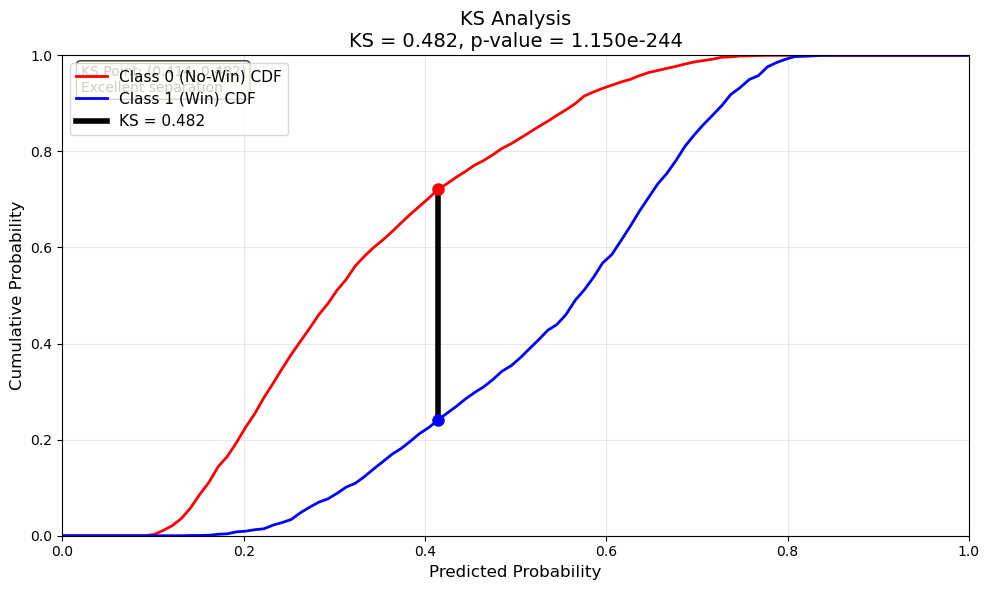

📊 KS Analysis Results:
   KS Statistic: 0.4819
   P-value: 1.150e-244
   Optimal threshold: 0.414
   Interpretation: Excellent separation


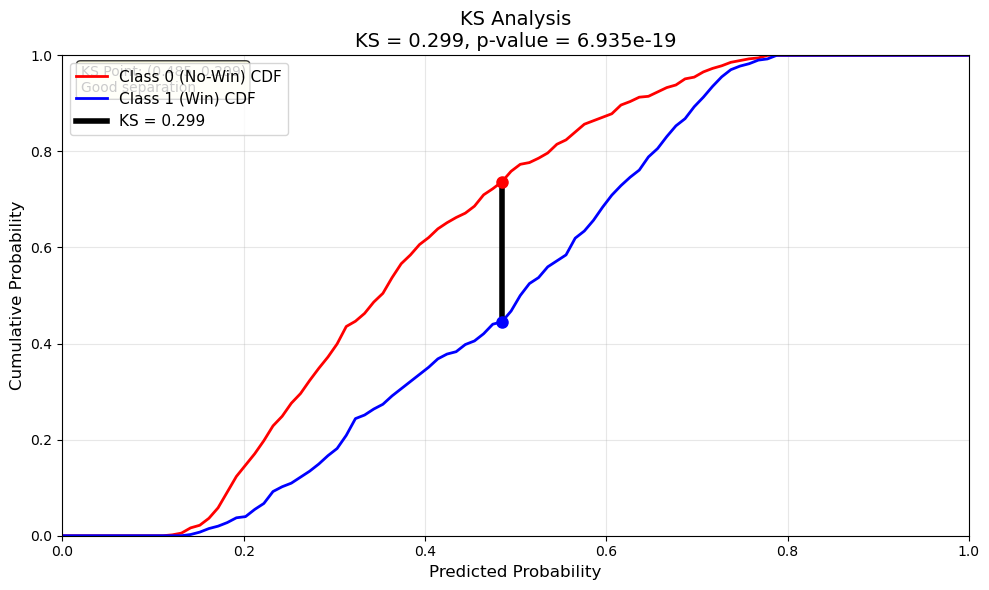

📊 KS Analysis Results:
   KS Statistic: 0.2993
   P-value: 6.935e-19
   Optimal threshold: 0.485
   Interpretation: Good separation


(0.2992975232729276, 6.934804854919666e-19, 0.48484848484848486)

In [84]:
plot_ks_simple(y_train_win, train_pred_proba_opt, )
plot_ks_simple(y_test_win, test_pred_proba_opt )

# train_pred_proba_opt
# test_pred_proba_opt 

In [85]:
# Precision, Recall, Accuracy vs Threshold Function
def plot_metrics_vs_threshold(y_true, y_prob, title="Metrics vs Threshold"):
    """
    Plot Precision, Recall, and Accuracy across different thresholds
    
    Parameters:
    y_true: actual labels (0,1)
    y_prob: predicted probabilities
    title: plot title
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import precision_score, recall_score, accuracy_score
    
    # Define threshold range
    thresholds = np.linspace(0.01, 0.99, 99)  # From 1% to 99%
    
    # Calculate metrics for each threshold
    precisions = []
    recalls = []
    accuracies = []
    
    for threshold in thresholds:
        # Make predictions with current threshold
        y_pred = (y_prob >= threshold).astype(int)
        
        # Calculate metrics (handle edge cases)
        try:
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            accuracy = accuracy_score(y_true, y_pred)
            
            precisions.append(precision)
            recalls.append(recall)
            accuracies.append(accuracy)
        except:
            precisions.append(0)
            recalls.append(0)
            accuracies.append(0)
    
    # Find optimal points
    # Best F1 score (harmonic mean of precision and recall)
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    best_f1_idx = np.argmax(f1_scores)
    best_f1_threshold = thresholds[best_f1_idx]
    
    # Best accuracy
    best_acc_idx = np.argmax(accuracies)
    best_acc_threshold = thresholds[best_acc_idx]
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    # Plot metrics
    ax.plot(thresholds, precisions, 'b-', linewidth=2, label='Precision', alpha=0.8)
    ax.plot(thresholds, recalls, 'r-', linewidth=2, label='Recall', alpha=0.8)
    ax.plot(thresholds, accuracies, 'g-', linewidth=2, label='Accuracy', alpha=0.8)
    ax.plot(thresholds, f1_scores, 'orange', linewidth=2, label='F1 Score', alpha=0.8, linestyle='--')
    
    # Mark optimal points
    ax.axvline(x=best_f1_threshold, color='orange', linestyle=':', alpha=0.7, 
               label=f'Best F1 Threshold ({best_f1_threshold:.3f})')
    ax.axvline(x=best_acc_threshold, color='green', linestyle=':', alpha=0.7,
               label=f'Best Accuracy Threshold ({best_acc_threshold:.3f})')
    ax.axvline(x=0.5, color='black', linestyle=':', alpha=0.5, label='Default (0.5)')
    
    # Formatting
    ax.set_xlabel('Threshold', fontsize=12)
    ax.set_ylabel('Metric Value', fontsize=12)
    ax.set_title(f'{title}\nOptimal Thresholds: F1={best_f1_threshold:.3f}, Accuracy={best_acc_threshold:.3f}', fontsize=14)
    ax.legend(fontsize=10, loc='center right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Add metrics summary box
    default_pred = (y_prob >= 0.5).astype(int)
    default_precision = precision_score(y_true, default_pred, zero_division=0)
    default_recall = recall_score(y_true, default_pred, zero_division=0)
    default_accuracy = accuracy_score(y_true, default_pred)
    
    optimal_pred = (y_prob >= best_f1_threshold).astype(int)
    optimal_precision = precision_score(y_true, optimal_pred, zero_division=0)
    optimal_recall = recall_score(y_true, optimal_pred, zero_division=0)
    optimal_accuracy = accuracy_score(y_true, optimal_pred)
    
    summary_text = f"""Default (0.5):
Precision: {default_precision:.3f}
Recall: {default_recall:.3f}
Accuracy: {default_accuracy:.3f}

Optimal F1 ({best_f1_threshold:.3f}):
Precision: {optimal_precision:.3f}
Recall: {optimal_recall:.3f}
Accuracy: {optimal_accuracy:.3f}"""
    
    ax.text(0.02, 0.35, summary_text, transform=ax.transAxes, fontsize=9, 
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"📊 Threshold Analysis Results:")
    print(f"   Best F1 Score: {max(f1_scores):.3f} at threshold {best_f1_threshold:.3f}")
    print(f"   Best Accuracy: {max(accuracies):.3f} at threshold {best_acc_threshold:.3f}")
    print(f"   Default (0.5): Precision={default_precision:.3f}, Recall={default_recall:.3f}, Accuracy={default_accuracy:.3f}")
    print(f"   Optimal F1: Precision={optimal_precision:.3f}, Recall={optimal_recall:.3f}, Accuracy={optimal_accuracy:.3f}")
    
    return {
        'thresholds': thresholds,
        'precisions': precisions,
        'recalls': recalls,
        'accuracies': accuracies,
        'f1_scores': f1_scores,
        'best_f1_threshold': best_f1_threshold,
        'best_accuracy_threshold': best_acc_threshold
    }

print("✅ Metrics vs Threshold plotting function created!")
print("Usage: results = plot_metrics_vs_threshold(y_true, y_pred_proba, 'Model Name')")

✅ Metrics vs Threshold plotting function created!
Usage: results = plot_metrics_vs_threshold(y_true, y_pred_proba, 'Model Name')


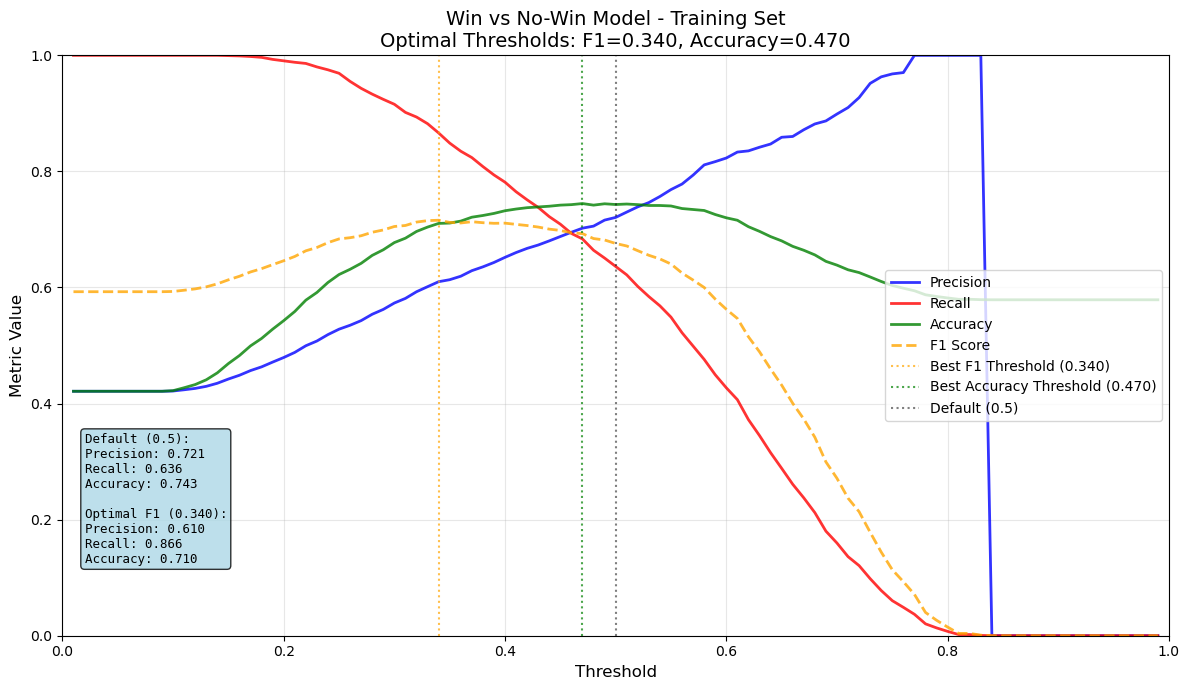

📊 Threshold Analysis Results:
   Best F1 Score: 0.716 at threshold 0.340
   Best Accuracy: 0.745 at threshold 0.470
   Default (0.5): Precision=0.721, Recall=0.636, Accuracy=0.743
   Optimal F1: Precision=0.610, Recall=0.866, Accuracy=0.710


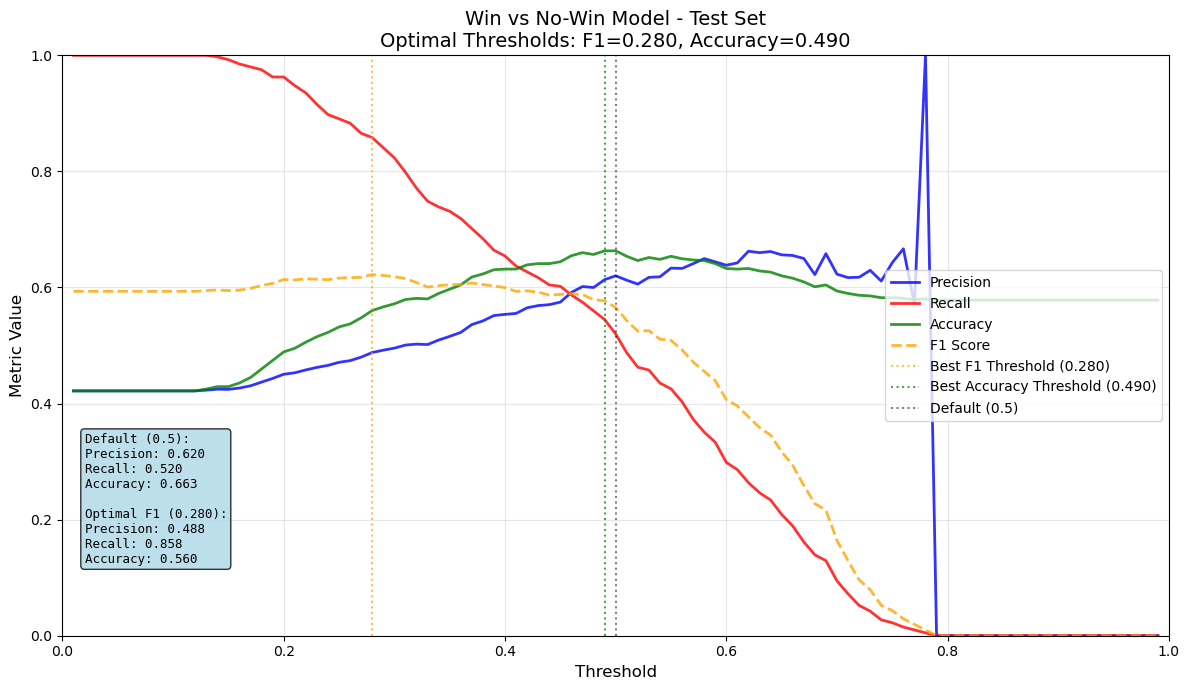

📊 Threshold Analysis Results:
   Best F1 Score: 0.622 at threshold 0.280
   Best Accuracy: 0.663 at threshold 0.490
   Default (0.5): Precision=0.620, Recall=0.520, Accuracy=0.663
   Optimal F1: Precision=0.488, Recall=0.858, Accuracy=0.560


{'thresholds': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
        0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
        0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
        0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
        0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
        0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
        0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
        0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
 'precisions': [0.4218258132214061,
  0.4218258132214061,
  0.4218258132214061,
  0.4218258132214061,
  0.4218258132214061,
  0.4218258132214061,
  0.4218258132214061,
  0.4218258132214061,
  0.4218258132214061,
  0.4218258132214061,
  0.4218258132214061,
  0.4218258132214061,
  0.4231578947368421,
  0.42478813559322

In [86]:
plot_metrics_vs_threshold(y_train_win, train_pred_proba_opt, title="Win vs No-Win Model - Training Set")
plot_metrics_vs_threshold(y_test_win, test_pred_proba_opt, title="Win vs No-Win Model - Test Set")